In [11]:
from collections import defaultdict
from collections import Counter

import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.nn.functional as F

import random
import pandas as pd
import numpy as np

from eunjeon import Mecab
from tqdm import tqdm_notebook

# 데이터 불러오기

In [14]:
data = pd.read_csv(r"..\data\test_file.csv")
data

,링크 순서,기업,평점,산업분류,직원의 기업 추천율,직원이 전망하는 성장 가능성,이 기업의 CEO 지지율,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,...,경영진,제목,장점,단점,경영진에게 바라는 점,각 리뷰 평점,직무,재직상태,지역,리뷰 좋아요 개수
0,0,유엔젤(주),3.0,IT/웹/통신,35%,5%,53%,2.8,3.2,2.9,...,2.2,"""관리만 하려하는 상위직급이 다수 사원 대리 과장은 적음""",10년차 정도면 it 중견기업 2~3년차 연봉에 맞먹음\n지원부서 대우가 높을수있음,경직된 상하관계\n명령하달식 커뮤니케이션\n대우개선에대한 희망고문,낙하산 및 고인물의 교체 필요\n실무자에 대한 대우개선 필요,1,IT/인터넷,전직원,경기,0
1,0,유엔젤(주),3.0,IT/웹/통신,35%,5%,53%,2.8,3.2,2.9,...,2.2,"""변화가 없다. 근 10년동안 비슷한 프로젝트만 유지하고 있다.""","자유로운 분위기, 타 IT 회사에 비해 경직되지 않고 근무를 할 수 있다.",성장세가 없다. 기존의 사업만 고수하고 신규사업에 대해 투자가 소홀한 편이다.,기존 사업보다는 신규사업에 투자해야 할 시기,3,IT/인터넷,현직원,경기,0
2,0,유엔젤(주),3.0,IT/웹/통신,35%,5%,53%,2.8,3.2,2.9,...,2.2,"""탄탄했던 회사 같음! 나쁘지 않아요! 복지좋고 편하게 다닐 수 있어요!""",사람들이랑 사이가 좋아서 즐겁게 다녔음 / 비품을 많이 사용할 수 있어서 좋았음\n...,집에서 출퇴근길이 멀어서 힘들었음/ 딱히 단점이 없었던 회사\n2년 열심히 다니고 ...,경영진에게 크게 바라는점은 없음 !! 그렇게 심한 터치가 없어서 편했나봄,2,IT/인터넷,전직원,경기,0
3,0,유엔젤(주),3.0,IT/웹/통신,35%,5%,53%,2.8,3.2,2.9,...,2.2,"""개발자와 기획자간의 괴리감이 크고 팀장과 팀원들과의 관계도 적대적인 분위기다. 줄...","해마다 복지카드가 나오고 원하는대로 쓸 수 있다. 연차나 휴가, 칼퇴에 대해 눈치보...","단, 일이 많다. 팀마다 분위기가 상이하고 줄을 잘 서야한다. 야근이 강요되지 않지...",신규 사업에 대한 투자는 좋지만 사람도 돌보는 회사가 됐으면 좋겠다.,3,IT/인터넷,전직원,서울,0
4,0,유엔젤(주),3.0,IT/웹/통신,35%,5%,53%,2.8,3.2,2.9,...,2.2,"""외국계 회사지만 실상은 국내 중소기업 분위기임. 합병이후 가치가 하락중""",사무용품 업계 1위업체. 워라벨은 보장 됨.연차사용 제약없음,연봉이 현저히 작음. 합병이후 시스템 이나 프로세스 통합이 미비함,직원들에 대한 복지나 연봉을 개선하여 동기부여가 될 수 있게 해줬으면 하는 바람,2,경영/기획/컨설팅,전직원,서울,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98348,65,하나은행(주),3.1,은행/금융업,43%,37%,44%,3.0,3.5,2.7,...,2.7,"""업계 중 연봉은 타은행대비 보통이나 잘하면 승진및 교육기회가 있는 곳""",역동적인 문화로 마케팅 ㅡ좋아하면 추천입니다 연봉은 보통수준,빡센문화 야근을 밥먹듯이하는사람많음 승진과열경쟁 부추김,야근을최소화하고 경쟁과 영업압박을 너무 주지않아야 임직원들이 버팀...,4,금융/재무,전직원,서울,0
98349,65,하나은행(주),3.1,은행/금융업,43%,37%,44%,3.0,3.5,2.7,...,2.7,"""가장효율적인 조직이며 위기에 강한은행 끝까지 마지막까지 살아남을 은행이다""",외환은행 통합으로 글로벌과 자산관리에 강점이 있음\n철저한 비용관리로 리스크관리가 우수,다양한 은행이 모인만큼 문화가 다르지만 성과로 평가하는 은행,단기실적 보단 지속가능 경영의 실현이 필요할때\n통합에 관한 제도 등의 결정은 빠르...,2,금융/재무,현직원,서울,0
98350,65,하나은행(주),3.1,은행/금융업,43%,37%,44%,3.0,3.5,2.7,...,2.7,"""합병으로 인해 성장성이 돋보이는 회사임. 앞으로 두 회사의 시너지가 기대""",안정적인 급여와 은행원이라는 것에 대한 자부심을 느낄 수 있음 여자행원들에 대한 복...,과도한 업무와 합병에 따른 전산처리가 아직 미비한점 인사제도에 대한 개선 필요,합병 시너지를 행원들까지 누릴 수 있게 인사제도 개선이 필요해 보입니다,3,금융/재무,현직원,서울,0
98351,65,하나은행(주),3.1,은행/금융업,43%,37%,44%,3.0,3.5,2.7,...,2.7,"""적당한 수준의 연봉과 적당한 수준의 개인생활을 유지하고 싶다면 추천""",개인 휴가가 보장되어 있고 타 은행에 비해 비교적 퇴근이 빠름. 분위기도 뭔가 혁신...,늘 그 자리에 머무는 연봉과 출신의 한계로 인한 넘사벽이 존재. 그리고 일단 비전없...,개인과 기업을 구분하지 말고 대우하길,2,금융/재무,전직원,서울,0


In [15]:
# 데이터 순서 섞기
# data=data.sample(frac=1)
# data=data.reset_index(drop=True)

In [17]:
label = pd.read_csv(r"..\data\label.csv", names=['기업','label'] )
label['label'] = label['label'].astype(int) 
label

,기업,label
1,조이시티(주),2
2,중소기업연구원,0
4,쿠팡(주),2
6,퍼스텍(주),1
7,평화홀딩스(주),1
...,...,...
1195,(주)디트라이브,2
1197,(주)스마트로,0
1200,미쓰비시다나베파마코리아(주),1
1201,법무법인(유)태평양,0


# 기업의 리뷰마다 labeling 해주기

In [18]:
total_data = pd.merge(data, label , on="기업", how='left')
total_data

,링크 순서,기업,평점,산업분류,직원의 기업 추천율,직원이 전망하는 성장 가능성,이 기업의 CEO 지지율,승진 기회 및 가능성,복지 및 급여,업무와 삶의 균형,...,제목,장점,단점,경영진에게 바라는 점,각 리뷰 평점,직무,재직상태,지역,리뷰 좋아요 개수,label
0,0,유엔젤(주),3.0,IT/웹/통신,35%,5%,53%,2.8,3.2,2.9,...,"""관리만 하려하는 상위직급이 다수 사원 대리 과장은 적음""",10년차 정도면 it 중견기업 2~3년차 연봉에 맞먹음\n지원부서 대우가 높을수있음,경직된 상하관계\n명령하달식 커뮤니케이션\n대우개선에대한 희망고문,낙하산 및 고인물의 교체 필요\n실무자에 대한 대우개선 필요,1,IT/인터넷,전직원,경기,0,NaN
1,0,유엔젤(주),3.0,IT/웹/통신,35%,5%,53%,2.8,3.2,2.9,...,"""변화가 없다. 근 10년동안 비슷한 프로젝트만 유지하고 있다.""","자유로운 분위기, 타 IT 회사에 비해 경직되지 않고 근무를 할 수 있다.",성장세가 없다. 기존의 사업만 고수하고 신규사업에 대해 투자가 소홀한 편이다.,기존 사업보다는 신규사업에 투자해야 할 시기,3,IT/인터넷,현직원,경기,0,NaN
2,0,유엔젤(주),3.0,IT/웹/통신,35%,5%,53%,2.8,3.2,2.9,...,"""탄탄했던 회사 같음! 나쁘지 않아요! 복지좋고 편하게 다닐 수 있어요!""",사람들이랑 사이가 좋아서 즐겁게 다녔음 / 비품을 많이 사용할 수 있어서 좋았음\n...,집에서 출퇴근길이 멀어서 힘들었음/ 딱히 단점이 없었던 회사\n2년 열심히 다니고 ...,경영진에게 크게 바라는점은 없음 !! 그렇게 심한 터치가 없어서 편했나봄,2,IT/인터넷,전직원,경기,0,NaN
3,0,유엔젤(주),3.0,IT/웹/통신,35%,5%,53%,2.8,3.2,2.9,...,"""개발자와 기획자간의 괴리감이 크고 팀장과 팀원들과의 관계도 적대적인 분위기다. 줄...","해마다 복지카드가 나오고 원하는대로 쓸 수 있다. 연차나 휴가, 칼퇴에 대해 눈치보...","단, 일이 많다. 팀마다 분위기가 상이하고 줄을 잘 서야한다. 야근이 강요되지 않지...",신규 사업에 대한 투자는 좋지만 사람도 돌보는 회사가 됐으면 좋겠다.,3,IT/인터넷,전직원,서울,0,NaN
4,0,유엔젤(주),3.0,IT/웹/통신,35%,5%,53%,2.8,3.2,2.9,...,"""외국계 회사지만 실상은 국내 중소기업 분위기임. 합병이후 가치가 하락중""",사무용품 업계 1위업체. 워라벨은 보장 됨.연차사용 제약없음,연봉이 현저히 작음. 합병이후 시스템 이나 프로세스 통합이 미비함,직원들에 대한 복지나 연봉을 개선하여 동기부여가 될 수 있게 해줬으면 하는 바람,2,경영/기획/컨설팅,전직원,서울,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98348,65,하나은행(주),3.1,은행/금융업,43%,37%,44%,3.0,3.5,2.7,...,"""업계 중 연봉은 타은행대비 보통이나 잘하면 승진및 교육기회가 있는 곳""",역동적인 문화로 마케팅 ㅡ좋아하면 추천입니다 연봉은 보통수준,빡센문화 야근을 밥먹듯이하는사람많음 승진과열경쟁 부추김,야근을최소화하고 경쟁과 영업압박을 너무 주지않아야 임직원들이 버팀...,4,금융/재무,전직원,서울,0,0.0
98349,65,하나은행(주),3.1,은행/금융업,43%,37%,44%,3.0,3.5,2.7,...,"""가장효율적인 조직이며 위기에 강한은행 끝까지 마지막까지 살아남을 은행이다""",외환은행 통합으로 글로벌과 자산관리에 강점이 있음\n철저한 비용관리로 리스크관리가 우수,다양한 은행이 모인만큼 문화가 다르지만 성과로 평가하는 은행,단기실적 보단 지속가능 경영의 실현이 필요할때\n통합에 관한 제도 등의 결정은 빠르...,2,금융/재무,현직원,서울,0,0.0
98350,65,하나은행(주),3.1,은행/금융업,43%,37%,44%,3.0,3.5,2.7,...,"""합병으로 인해 성장성이 돋보이는 회사임. 앞으로 두 회사의 시너지가 기대""",안정적인 급여와 은행원이라는 것에 대한 자부심을 느낄 수 있음 여자행원들에 대한 복...,과도한 업무와 합병에 따른 전산처리가 아직 미비한점 인사제도에 대한 개선 필요,합병 시너지를 행원들까지 누릴 수 있게 인사제도 개선이 필요해 보입니다,3,금융/재무,현직원,서울,0,0.0
98351,65,하나은행(주),3.1,은행/금융업,43%,37%,44%,3.0,3.5,2.7,...,"""적당한 수준의 연봉과 적당한 수준의 개인생활을 유지하고 싶다면 추천""",개인 휴가가 보장되어 있고 타 은행에 비해 비교적 퇴근이 빠름. 분위기도 뭔가 혁신...,늘 그 자리에 머무는 연봉과 출신의 한계로 인한 넘사벽이 존재. 그리고 일단 비전없...,개인과 기업을 구분하지 말고 대우하길,2,금융/재무,전직원,서울,0,0.0


In [19]:
total_data = total_data.dropna(axis=0)
total_data.reset_index(inplace=True)
total_data['label'] = total_data['label'].astype(int)
total_data

c:\users\kym\.conda\envs\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,index,링크 순서,기업,평점,산업분류,직원의 기업 추천율,직원이 전망하는 성장 가능성,이 기업의 CEO 지지율,승진 기회 및 가능성,복지 및 급여,...,제목,장점,단점,경영진에게 바라는 점,각 리뷰 평점,직무,재직상태,지역,리뷰 좋아요 개수,label
0,102,1,조이시티(주),3.0,IT/웹/통신,41%,14%,41%,2.8,2.7,...,"""개발자가 무난하게 다니기 좋은 회사.. 부서차이가 있지만 야근도 많지는 않음""","수평적인 분위기 지향 (호칭은 전부 ~님으로 통일), 연차 눈치없이 사용가능","은근 사내정치가 존재, 직원들 연령대가 젊지만 젊은 꼰대도 상당히 존재",전망 있는 사업을 추진했으면 좋겠음. 중국쪽은 그나마 괜찮은거 같지만 한국에서 최근...,3,IT/인터넷,전직원,경기,0,2
1,103,1,조이시티(주),3.0,IT/웹/통신,41%,14%,41%,2.8,2.7,...,"""나름 안정적으로 다닐 수 있는 곳, 프리스타일 덕에 회사 상황이 악화될 가능성은 적음""",5년 채우면 1달 유갑휴가 + 휴가비 지원\n근태 빡세지 않음\n게임 회사 중에는 ...,모바일에서 성공작이 별로 없음\n경영진 입김이 센편이라 회의가 길어지는 편\n모회사...,꽂히면 끝까지 투자하는 스타일이라 종종 다소 무모하다는 느낌의 투자가 발생하는 것 ...,4,IT/인터넷,현직원,경기,0,2
2,104,1,조이시티(주),3.0,IT/웹/통신,41%,14%,41%,2.8,2.7,...,"""철저한 성과주의 조직. 게임업계다 보니 빡셈은 기본. 신입이 성장하기엔 힘듦.""","1. 권한의 자유로움\n인트라넷, 통계툴 등 신입사원이 열람할 수 있는 정보가 많은...","1. 신입 교육 시스템의 부족\n일련의 신입 교육 프로세스가 있는 것은 맞으나, 교...",신입 교육 시스템 좀 확실히 만들어 주셨으면 좋겠어요. 물어보고 어깨너머로 배우는 ...,3,IT/인터넷,전직원,경기,0,2
3,105,1,조이시티(주),3.0,IT/웹/통신,41%,14%,41%,2.8,2.7,...,"""무난한 회사였으나 사원에 대한 관심이 그다지 없어보였음. 개인의 역량에 따라 많이...",꽤 자유로운 분위기. 팀원간의 사이가꽤 좋아보였고 어느정도 챙겨주려고는 함. 회사자...,퇴근할때 눈치가 보였음. 파트간의 갈등이 꽤 있어서 사이에서 눈치보고 어떻게 해야할...,경영진과는 직접적인 대화는 잘 안해서 모르겠지만 조금 더 부드러운 분위기면 좋을 것...,3,IT/인터넷,전직원,경기,0,2
4,106,1,조이시티(주),3.0,IT/웹/통신,41%,14%,41%,2.8,2.7,...,"""굉장히 자유로운 분위기이며, 눈치볼 일이 거의 없다. 직원들 간 유대관계 좋은 편""",야근이 많지는 않으나 야근할 경우 택시비와 식대 있음. 연차 반차 눈치 안봄 연령대...,야근은 팀바팀으로 야근 많이 하는 팀이 따로 있음. 아직 포괄임금제인점? 일을 편하...,포괄임금제가 없어지면 좋겠다. 사옥이 따로 생기면 좋겠다.\n식비가 너무 많이 든다,4,IT/인터넷,현직원,경기,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45810,98348,65,하나은행(주),3.1,은행/금융업,43%,37%,44%,3.0,3.5,...,"""업계 중 연봉은 타은행대비 보통이나 잘하면 승진및 교육기회가 있는 곳""",역동적인 문화로 마케팅 ㅡ좋아하면 추천입니다 연봉은 보통수준,빡센문화 야근을 밥먹듯이하는사람많음 승진과열경쟁 부추김,야근을최소화하고 경쟁과 영업압박을 너무 주지않아야 임직원들이 버팀...,4,금융/재무,전직원,서울,0,0
45811,98349,65,하나은행(주),3.1,은행/금융업,43%,37%,44%,3.0,3.5,...,"""가장효율적인 조직이며 위기에 강한은행 끝까지 마지막까지 살아남을 은행이다""",외환은행 통합으로 글로벌과 자산관리에 강점이 있음\n철저한 비용관리로 리스크관리가 우수,다양한 은행이 모인만큼 문화가 다르지만 성과로 평가하는 은행,단기실적 보단 지속가능 경영의 실현이 필요할때\n통합에 관한 제도 등의 결정은 빠르...,2,금융/재무,현직원,서울,0,0
45812,98350,65,하나은행(주),3.1,은행/금융업,43%,37%,44%,3.0,3.5,...,"""합병으로 인해 성장성이 돋보이는 회사임. 앞으로 두 회사의 시너지가 기대""",안정적인 급여와 은행원이라는 것에 대한 자부심을 느낄 수 있음 여자행원들에 대한 복...,과도한 업무와 합병에 따른 전산처리가 아직 미비한점 인사제도에 대한 개선 필요,합병 시너지를 행원들까지 누릴 수 있게 인사제도 개선이 필요해 보입니다,3,금융/재무,현직원,서울,0,0
45813,98351,65,하나은행(주),3.1,은행/금융업,43%,37%,44%,3.0,3.5,...,"""적당한 수준의 연봉과 적당한 수준의 개인생활을 유지하고 싶다면 추천""",개인 휴가가 보장되어 있고 타 은행에 비해 비교적 퇴근이 빠름. 분위기도 뭔가 혁신...,늘 그 자리에 머무는 연봉과 출신의 한계로 인한 넘사벽이 존재. 그리고 일단 비전없...,개인과 기업을 구분하지 말고 대우하길,2,금융/재무,전직원,서울,0,0


# label 비중

In [20]:
label_cnt = list(total_data.groupby('label').size())

In [21]:
label_per = []

for i in range(len(label_cnt)):
    per = label_cnt[i]/sum(label_cnt) * 100
    label_per.append(per)

In [22]:
label_per

[42.74800829422678, 18.192731638109787, 39.05926006766343]

# 특수문자 제거

In [23]:
data['제목'] = data['제목'].str.replace("[^a-zA-Zㄱ-ㅎ가-힣0-9]", " ")
data['장점'] = data['장점'].str.replace("[^a-zA-Zㄱ-ㅎ가-힣0-9]", " ")
data['단점'] = data['단점'].str.replace("[^a-zA-Zㄱ-ㅎ가-힣0-9]", " ")
data['경영진에게 바라는 점'] = data['경영진에게 바라는 점'].str.replace("[^a-zA-Zㄱ-ㅎ가-힣0-9]", " ")

# 형태소화, pos태그 카운트, 불용품사, 불용어, 단어 길이 1개 토큰 제거

In [25]:
total_word=[]
tag_count=[]
mecab=Mecab()

for i in tqdm_notebook(range(len(total_data))):
    
    
    mecab_text=total_data['장점'][i]

    Mecab_tag=mecab.pos(mecab_text)
    
    tag_count.append(Counter(Mecab_tag).most_common())
    

    mecab.morphs(mecab_text)
    
    
    stopPos=['MAJ','IC','JKS','JKC','JKG','JKO','JKB','JKV','JKQ','JX','JC','XSA','EP','EF','EC','ETN','ETM','VV','VA','VX','MM','SF']

    stopwords = pd.read_csv('../data/stopwords.csv', dtype=str, sep=',', encoding='utf-8', names=['stopword'])
    stopWord = np.array(stopwords['stopword'])

    
    # 불용품사, 불용어 제거 및 한 글자 토큰 제거
    word = []
    for tag in Mecab_tag:
        if tag[1] not in stopPos:
            if tag[0] not in stopWord :
                if len(tag[0]) > 1 :
                    word.append(tag[0])
       
    
    
    total_word.append(word)

c:\users\kym\.conda\envs\venv\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/45815 [00:00<?, ?it/s]

# 특정 갯수 이하 토큰 제거

In [26]:
cnt_ls =[]

for a in range(len(total_word)):
    cnt_ls += total_word[a]
    
counter_word=Counter(cnt_ls).most_common()  

c=counter_word

In [27]:
c

[('분위기', 10483),
 ('복지', 9596),
 ('업무', 9435),
 ('자유', 7838),
 ('가능', 6800),
 ('연차', 6561),
 ('근무', 6355),
 ('연봉', 6215),
 ('사람', 5594),
 ('직원', 5005),
 ('문화', 4816),
 ('눈치', 3848),
 ('사용', 3753),
 ('로운', 3722),
 ('다양', 3579),
 ('장점', 3503),
 ('수평', 3496),
 ('안정', 3457),
 ('많이', 3406),
 ('휴가', 3349),
 ('부서', 2896),
 ('야근', 2681),
 ('지원', 2644),
 ('퇴근', 2641),
 ('급여', 2598),
 ('보장', 2435),
 ('비교', 2366),
 ('기회', 2365),
 ('환경', 2292),
 ('경험', 2268),
 ('생각', 2212),
 ('강도', 2162),
 ('사내', 2123),
 ('때문', 2063),
 ('출퇴근', 2049),
 ('제공', 2029),
 ('수준', 2019),
 ('공기업', 1957),
 ('배울', 1862),
 ('매우', 1834),
 ('비해', 1783),
 ('대한', 1767),
 ('교육', 1706),
 ('조직', 1691),
 ('경우', 1634),
 ('개인', 1597),
 ('정도', 1595),
 ('입니다', 1588),
 ('기관', 1541),
 ('체계', 1522),
 ('직장', 1470),
 ('나름', 1417),
 ('최고', 1411),
 ('출근', 1384),
 ('수당', 1383),
 ('성장', 1378),
 ('자부심', 1334),
 ('위치', 1308),
 ('합니다', 1235),
 ('제도', 1196),
 ('회식', 1184),
 ('본인', 1152),
 ('노력', 1152),
 ('대부분', 1134),
 ('워라', 1114),
 ('정말', 1097),
 (

In [28]:
# 5개 이하
c_5 = c[-9935:]
c_5

[('Sk', 4),
 ('다닐수록', 4),
 ('낮잠', 4),
 ('~)', 4),
 ('총괄', 4),
 ('불분명', 4),
 ('일례', 4),
 ('도달', 4),
 ('경지', 4),
 ('허울', 4),
 ('진화', 4),
 ('긴장', 4),
 ('게이머', 4),
 ('형평', 4),
 ('선사', 4),
 ('들으려고', 4),
 ('허례허식', 4),
 ('중요히', 4),
 ('수소', 4),
 ('내라', 4),
 ('져도', 4),
 ('밤낮', 4),
 ('소등', 4),
 ('곤란', 4),
 ('뭉침', 4),
 ('전개', 4),
 ('확연', 4),
 ('윤택', 4),
 ('걸려서', 4),
 ('섹터', 4),
 ('개국', 4),
 ('시책', 4),
 ('아빠', 4),
 ('취침', 4),
 ('농후', 4),
 ('바글바글', 4),
 ('신의', 4),
 ('서지', 4),
 ('에코', 4),
 ('월화', 4),
 ('쾌활', 4),
 ('목욕탕', 4),
 ('벌이', 4),
 ('중산', 4),
 ('종각', 4),
 ('야외', 4),
 ('방지법', 4),
 ('당기', 4),
 ('만년', 4),
 ('PE', 4),
 ('구상', 4),
 ('도구', 4),
 ('서든', 4),
 ('주워', 4),
 ('하드웨어', 4),
 ('%,', 4),
 ('법칙', 4),
 ('수신', 4),
 ('트레이딩', 4),
 ('ib', 4),
 ('솔선수범', 4),
 ('드신', 4),
 ('종각역', 4),
 ('밥집', 4),
 ('기부', 4),
 ('이관', 4),
 ('전수', 4),
 ('기보', 4),
 ('위해선', 4),
 ('양반', 4),
 ('이수', 4),
 ('원시', 4),
 ('으쓱', 4),
 ('예측', 4),
 ('휴가일', 4),
 ('식스', 4),
 ('상세히', 4),
 ('시칼', 4),
 ('막중', 4),
 ('둥글', 4),
 ('수력', 4),
 ('개

In [29]:
c_5_ls=[]

for z in range(len(c_5)):
    c_5_ls.append(c_5[z][0])
#5개 이하 리스트로만들기

In [30]:
ls_total=[]

s = set(c_5_ls)
for i in tqdm_notebook(range(len(total_word))):
    ls = [x for x in total_word[i] if x not in s]
    ls_total.append(ls)
    
# 5개 이하 빼기

c:\users\kym\.conda\envs\venv\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


  0%|          | 0/45815 [00:00<?, ?it/s]

# 문서 최대 길이 구하기

In [31]:
from collections import Counter

In [32]:
max_len =[]
for i in range(len(total_word)):
    max_len.append(len(total_word[i]))

max(max_len)

162

In [33]:
count_len = Counter(max_len).most_common()
cnt_sort = count_len.sort(reverse=True)
count_len

[(162, 3),
 (155, 1),
 (150, 1),
 (141, 1),
 (139, 1),
 (137, 1),
 (135, 1),
 (134, 1),
 (126, 1),
 (125, 1),
 (120, 1),
 (118, 1),
 (117, 1),
 (112, 1),
 (108, 1),
 (107, 1),
 (105, 1),
 (104, 3),
 (103, 13),
 (102, 2),
 (100, 3),
 (99, 2),
 (98, 2),
 (95, 4),
 (94, 1),
 (93, 1),
 (91, 1),
 (89, 4),
 (88, 1),
 (85, 1),
 (83, 2),
 (82, 4),
 (81, 6),
 (80, 2),
 (79, 3),
 (78, 3),
 (77, 3),
 (76, 2),
 (75, 3),
 (74, 2),
 (73, 4),
 (72, 3),
 (71, 3),
 (70, 3),
 (69, 5),
 (68, 7),
 (67, 3),
 (66, 4),
 (65, 6),
 (64, 5),
 (63, 4),
 (62, 5),
 (61, 10),
 (60, 7),
 (59, 9),
 (58, 4),
 (57, 5),
 (56, 8),
 (55, 16),
 (54, 5),
 (53, 10),
 (52, 6),
 (51, 8),
 (50, 20),
 (49, 20),
 (48, 15),
 (47, 24),
 (46, 23),
 (45, 20),
 (44, 25),
 (43, 28),
 (42, 46),
 (41, 31),
 (40, 40),
 (39, 37),
 (38, 39),
 (37, 79),
 (36, 45),
 (35, 51),
 (34, 58),
 (33, 70),
 (32, 94),
 (31, 88),
 (30, 120),
 (29, 123),
 (28, 132),
 (27, 158),
 (26, 228),
 (25, 256),
 (24, 261),
 (23, 303),
 (22, 392),
 (21, 436),
 (20,

### 문서 길이 데이터 시각화 및 정규분포화

In [34]:
import matplotlib.pyplot as plt

In [36]:
len_data = []

for i in range(len(ls_total)):
    len_data.append(len(ls_total[i]))

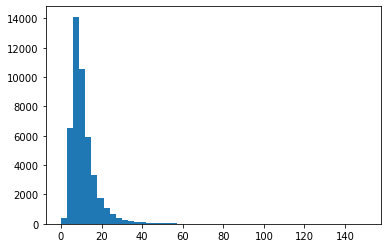

In [42]:
plt.hist(len_data, bins=50)
plt.show()

# 불용어, 불용품사, 1글자 토큰 제거 후 토큰이 없는 리뷰 제거

In [0]:
for i in range(len(total_word)-1, -1 , -1):
    if len(total_word[i]) == 0:
        del total_word[i]

In [0]:
len(total_word)

38086

# Train, Test 나누기

In [0]:
x_train = total_word[:30400]
x_test = total_word[30400:]
y_train = total_data['label'][:30400].values.tolist()
y_test = total_data['label'][30400:].values.tolist()

# Padding

In [0]:
# Sequence Length를 맞추기 위한 padding
def add_padding(token_ls, max_len):
    pad = '<PAD>'
    seq_length_ls = []
    
    for i, tokens in enumerate(token_ls):
        seq_length = len(tokens)
        
        # 짧으면 padding을 추가
        if seq_length < max_len:
            seq_length_ls.append(seq_length)
            token_ls[i] += [pad] * (max_len - seq_length)
        
        # 길이가 길면, max_len까지의 token만 사용
        elif seq_length >= max_len:
            seq_length_ls.append(max_len)
            token_ls[i] = tokens[:max_len]
            
    return token_ls, seq_length_ls

In [0]:
max_sequence_length = 50
x_train, x_train_seq_length = add_padding(x_train, max_sequence_length)
x_test, x_test_seq_length = add_padding(x_test, max_sequence_length)

# Converting token to index

In [0]:
# 단어에 대한 idx 부여
def convert_token_to_idx(token_ls):
    for tokens in token_ls:
        yield [token2idx[token] for token in tokens]
    return

In [0]:
token2idx = defaultdict(lambda: len(token2idx))
pad = token2idx['<PAD>']

x_train = list(convert_token_to_idx(x_train))
x_test = list(convert_token_to_idx(x_test))

idx2token = {val : key for key,val in token2idx.items()}

In [0]:
' '.join([idx2token[x] for x in x_train[30]])

'회사 재무 구조 걱정 없이 오래 회사 직원 누릴 복지 업계 상위 연봉 중상 커리어 시작 사회 초년병 추천 회사 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

### Packing을 위해, 긴 문장이 위로 오도록 순서를 sorting and Variable로 변환

In [0]:
def sort_by_sequence_length(x, y, seq_len):
    sorted_idx = np.argsort(np.array(seq_len))[::-1]
    
    x = Variable(torch.LongTensor(np.array(x)[sorted_idx]))
    y = Variable(torch.LongTensor(np.array(y)[sorted_idx]))
    seq_len = Variable(torch.LongTensor(np.array(seq_len)[sorted_idx]))
    
    return x, y, seq_len

In [0]:
x_train, y_train, x_train_seq_length = sort_by_sequence_length(x_train, y_train, x_train_seq_length)
x_test, y_test, x_test_seq_length = sort_by_sequence_length(x_test, y_test, x_test_seq_length)

# Pretrain 된 word2vec 모델 벡터 값 불러오기

In [0]:
# import gensim

# wv_model = gensim.models.KeyedVectors.load('Word2vec_model')
# weights = torch.FloatTensor(wv_model.wv.vectors)

In [0]:
# embedding = nn.Embedding.from_pretrained(weights)
# # Get embeddings for index 1
# input = torch.LongTensor([1])
# embedding(input)

# LSTM

In [0]:
class LSTM(nn.Module):
    def __init__(self, token2idx, max_sequence, vocab_size, embed_size, hid_size, n_layers, dropout, bidirectional, n_category):
        super(LSTM, self).__init__() 
        self.vocab_size = vocab_size                # 고유한 단어의 수
        self.embed_size = embed_size                # 임베딩 차원의 크기
        self.padding_index = token2idx['<PAD>']     # 패딩 토큰
        
        self.embed = nn.Embedding(
            num_embeddings=vocab_size, 
            embedding_dim=embed_size, 
            padding_idx=self.padding_index
        )
        
        self.max_sequence = max_sequence           # 한 문장의 최대 길이
        self.hid_size = hid_size                   # LSTM 뉴런의 갯수
        self.n_layers = n_layers                   # LSTM layer의 수
        self.drouput = dropout                     # 드롭아웃
        self.n_category = n_category               # 분류 카테고리 갯수
        self.bidirectional = bidirectional         # optinal, True : bidirectional 
        
        self.lstm = nn.LSTM(embed_size, hid_size, n_layers, batch_first=True, bidirectional=True)
        
        if bidirectional:
            input_dim = 2*hid_size*max_sequence
        else:
            input_dim = hid_size*max_sequence

        self.lin = nn.Linear(input_dim, n_category)
        self.outputs = []
        
    def init_hidden(self, batch_size):
        # 최초에 h_0와 c_0의 초기값 부여 (n_layers, batch_size, hid_size(n_neuron))
        # bidirectional일 경우, (2*n_layers, batch_size, hid_size)
        if self.bidirectional:
            h_0 = Variable(torch.randn(2*self.n_layers, batch_size, self.hid_size)) * 0.1
            c_0 = Variable(torch.randn(2*self.n_layers, batch_size, self.hid_size)) * 0.1
        else:
            h_0 = Variable(torch.randn(self.n_layers, batch_size, self.hid_size)) * 0.1
            c_0 = Variable(torch.randn(self.n_layers, batch_size, self.hid_size)) * 0.1
        return (h_0, c_0)    
    
    def forward(self, x, x_sequence_length):
        # init h randomly
        batch_size = x.size(0)
        self.h_c = self.init_hidden(batch_size)
        
        # embedding
        x = self.embed(x) # sequence_length(max_len), batch_size, embed_size
        
        # packing for LSTM
        x = torch.nn.utils.rnn.pack_padded_sequence(x, x_sequence_length, batch_first=True)
        
        # LSTM
        output, self.h_c = self.lstm(x, self.h_c)
        
        # unpack
        # unpacking 과정에서, size(1) S가 가장 긴 sequence 길이를 갖는 data에 맞춰진다.
        # S가 max_sequence_length로 고정되는 것이 아님을 주의
        x, _ = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        #print(x.shape)
        
        # flatten
        x = x.contiguous()
        x = x.view(batch_size, -1)
        
        # fully-connect
        logit = self.lin(x)
        
        return logit

In [0]:
params = {
    'token2idx' : token2idx,
    'max_sequence' : 50,
    'vocab_size' : len(token2idx),
    'embed_size' : 30,
    'hid_size' : 32,
    'n_layers' : 2,
    'dropout' : 0.5,
    'bidirectional' : True,
    'n_category' : 5
}

In [0]:
model = LSTM(**params)

In [0]:
model

LSTM(
  (embed): Embedding(13974, 30, padding_idx=0)
  (lstm): LSTM(30, 32, num_layers=2, batch_first=True, bidirectional=True)
  (lin): Linear(in_features=3200, out_features=5, bias=True)
)

# Train

In [0]:
def adjust_learning_rate(optimizer, epoch, init_lr=0.001, lr_decay_epoch=10):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to %s'%(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [0]:
epochs = 20
lr = 0.01
batch_size = 10000

train_idx = np.arange(x_train.size(0))
test_idx = np.arange(x_test.size(0))
optimizer = torch.optim.Adam(model.parameters(),lr)
criterion = nn.CrossEntropyLoss(reduction='sum')

loss_ls = []

for epoch in range(1, epochs+1):
    model.train()
    
    # input 데이터 순서 섞기
    random.shuffle(train_idx)
    x_train, y_train = x_train[train_idx], y_train[train_idx]
    x_train_seq_length = x_train_seq_length[train_idx]
    
    train_loss = 0
    
    for start_idx, end_idx in zip(range(0, x_train.size(0), batch_size),
                                  range(batch_size, x_train.size(0)+1, batch_size)):
        # batch 뽑기
        x_batch = x_train[start_idx : end_idx]
        y_batch = y_train[start_idx : end_idx].long()
        x_batch_seq_length = x_train_seq_length[start_idx: end_idx]
        
        # sequence 순서대로 정렬하기
        x_batch, y_batch, x_batch_seq_length = sort_by_sequence_length(x_batch, y_batch, x_batch_seq_length)
        
        scores = model(x_batch, x_batch_seq_length)
        predict = F.softmax(scores, dim=1).argmax(dim = 1)
        
        acc = (predict == y_batch).sum().item() / batch_size
        
        loss = criterion(scores, y_batch)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Train epoch : %s,  loss : %s,  accuracy :%.3f'%(epoch, train_loss / batch_size, acc))
    print('=================================================================================================')
    
    loss_ls.append(train_loss)
    optimizer = adjust_learning_rate(optimizer, epoch, lr, 100) # adjust learning_rate while training
    
    if (epoch) % 5 == 0:
        model.eval()
        scores = model(x_test, x_test_seq_length)
        predict = F.softmax(scores, dim=1).argmax(dim = 1)
        
        acc = (predict == y_test.long()).sum().item() / y_test.size(0)
        loss = criterion(scores, y_test.long())
        
        print('*************************************************************************************************')
        print('*************************************************************************************************')
        print('Test Epoch : %s, Test Loss : %.03f , Test Accuracy : %.03f'%(epoch, loss.item()/y_test.size(0), acc))
        print('*************************************************************************************************')
        print('*************************************************************************************************')

Train epoch : 1,  loss : 4.76512744140625,  accuracy :0.294
Train epoch : 2,  loss : 4.51932783203125,  accuracy :0.380
Train epoch : 3,  loss : 4.20841650390625,  accuracy :0.429
Train epoch : 4,  loss : 3.93385419921875,  accuracy :0.477
Train epoch : 5,  loss : 3.69765224609375,  accuracy :0.514
*************************************************************************************************
*************************************************************************************************
Test Epoch : 5, Test Loss : 1.278 , Test Accuracy : 0.476
*************************************************************************************************
*************************************************************************************************
Train epoch : 6,  loss : 3.467755859375,  accuracy :0.543
Train epoch : 7,  loss : 3.2453755859375,  accuracy :0.582
Train epoch : 8,  loss : 3.03221015625,  accuracy :0.609
Train epoch : 9,  loss : 2.83741484375,  accuracy :0.638
Train epoch : 10,  